<a href="https://colab.research.google.com/github/leeliangchao/-spatiotemporal-pedict/blob/main/%E8%A7%A3%E5%86%B3%E4%BA%86%E5%A4%9A%E6%AD%A5%E9%A2%84%E6%B5%8B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [39]:
# !pip install mlxtend==0.18
# from mlxtend.plotting import heatmap


## 范围选择

In [40]:
Longitude_Index = 54    #经度索引
Longitude_End = 62 +1   #经度索引

Latitude_Index = 17  # 纬度索引
Latitude_End = 31 +1 # 纬度索引

In [41]:
Sample = np.load('/content/drive/MyDrive/TEC/日本3台站/CODE/TEC.npy')

In [42]:
Sample.shape

(71, 73, 25, 366, 1)

In [43]:
Target_region = Sample[Latitude_Index:Latitude_End, Longitude_Index:Longitude_End,:,:,:]

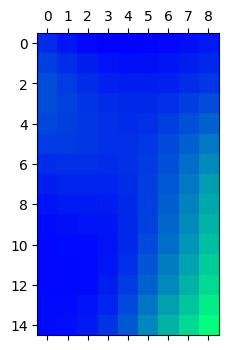

matplotlib.image.AxesImage

In [44]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
line=ax.matshow(Target_region[:,:,-2,0,0], cmap = plt.cm.winter)
plt.show()
type(line)

In [45]:
from matplotlib import animation

In [46]:
def animate(i):
  line.set_data(Target_region[:,:,i,0,0])
  return line,
def init():
  line.set_data(Target_region[:,:,0,0,0])
  return line,
ani = animation.FuncAnimation(fig=fig, func=animate,frames=25,init_func=init,interval=200,blit=False)
ani.save('ani.gif', writer='pillow')
plt.show()

### 样本制作

In [47]:
###################绘图###################
import matplotlib.pyplot as plt
###################标准化###################
from sklearn.preprocessing import MinMaxScaler

In [48]:
Target_region.shape

(15, 9, 25, 366, 1)

In [49]:
data = np.swapaxes(Target_region, 0,2)
data = np.swapaxes(data, 1,3)
data = np.swapaxes(data, 0,1)

In [50]:
data.shape

(366, 25, 15, 9, 1)

In [51]:
data = np.delete(data,[-1], axis=0);data.shape

(365, 25, 15, 9, 1)

In [52]:
data = data.reshape(-1,15,9,1)

In [53]:
data.shape

(9125, 15, 9, 1)

In [54]:
data = data[::2]

In [55]:
data.shape

(4563, 15, 9, 1)

In [56]:
# 数据集划分
def create_dataset(data, look_back=91, forward=26):
  x = []
  y = []
  for i in range(data.shape[0]-(look_back+forward)+1):
    x.append(data[i:i+look_back,:,:,:])
    y.append(data[i+look_back:i+look_back+forward,:,:,:])
  return (np.array(x), np.array(y))


In [57]:
a,b = create_dataset(data)

In [58]:
a.shape,b.shape

((4447, 91, 15, 9, 1), (4447, 26, 15, 9, 1))

In [59]:
# len(df)为df多少行
pot = round(0.8 * a.shape[0])
pot

3558

In [60]:
x_train, y_train = a[:pot],b[:pot]
x_test, y_test = a[pot:],b[pot:]
# y_train = np.expand_dims(y_train, 1)
# y_test = np.expand_dims(y_test, 1)

In [61]:
x_train.shape, x_test.shape,y_test.shape

((3558, 91, 15, 9, 1), (889, 91, 15, 9, 1), (889, 26, 15, 9, 1))

### LearningRateScheduler调整学习率

In [62]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [63]:
def scheduler(epoch):
    if epoch % 40 ==0 :
        lr = K.get_value(tcn.optimizer.lr)
        if lr > 1e-5:
            K.set_value(tcn.optimizer.lr, lr *0.5)
            print('lr changed to {}'.format(lr * 0.5))
    return K.get_value(tcn.optimizer.lr)

In [64]:
reduce_lr = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='loss', 
                               patience=20, 
                               min_delta=1e-5,
                               mode='auto',
                               restore_best_weights=False,#是否从具有监测数量的最佳值的时期恢复模型权重
                               verbose=2)

In [65]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D,Conv2D,Conv3D,BatchNormalization,Flatten,RepeatVector,Reshape
from tensorflow.keras import Input, Model, Sequential
from sklearn.metrics import mean_squared_error

In [66]:
# 自定义损失函数
def my_metric_fn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
# Loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0, filter_size=3))

In [67]:
#输入维数
tcn = Sequential()
input_layer =Input(shape=(x_train.shape[1:]))
tcn.add(input_layer)
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=False
    )
)
tcn.add(BatchNormalization())
# ###############################
tcn.add(Flatten())
tcn.add(RepeatVector(13*2))
tcn.add(Reshape((13*2,15,9,32)))
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(Conv3D(filters=1, kernel_size=(1,1,1),activation="relu", padding="same"))
tcn.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=root_mean_squared_error)# RMSE
tcn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 91, 15, 9, 32)     38144     
                                                                 
 batch_normalization_6 (Batc  (None, 91, 15, 9, 32)    128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 91, 15, 9, 32)     32896     
                                                                 
 batch_normalization_7 (Batc  (None, 91, 15, 9, 32)    128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 91, 15, 9, 32)     32896     
                                                                 
 batch_normalization_8 (Batc  (None, 91, 15, 9, 32)   

In [68]:

# history=tcn.fit(x_train,y_train, 
#         epochs=121, batch_size=128,validation_data=[x_test, y_test], callbacks=[reduce_lr])


In [69]:
# history.history.keys() #查看history中存储了哪些参数

In [70]:
# plt.plot(history.epoch,history.history.get('my_metric_fn')[:]) #画出随着epoch增大loss的变化图
#plt.plot(history.epoch,history.history.get('acc'))#画出随着epoch增大准确率的变化图

In [71]:
# plt.plot(history.epoch, history.history.get('lr'))

In [72]:
from tensorflow.keras.models import load_model
tcn = load_model('/content/7d2d.h5',custom_objects={'root_mean_squared_error':root_mean_squared_error})

In [73]:
tcn.evaluate(x_test, y_test)

28/28 [==============================] - 141s 5s/step - loss: 1.9653


1.965349555015564

In [74]:
predict = tcn.predict(x_test)

28/28 [==============================] - 131s 5s/step


In [75]:
predict.shape

(889, 26, 15, 9, 1)

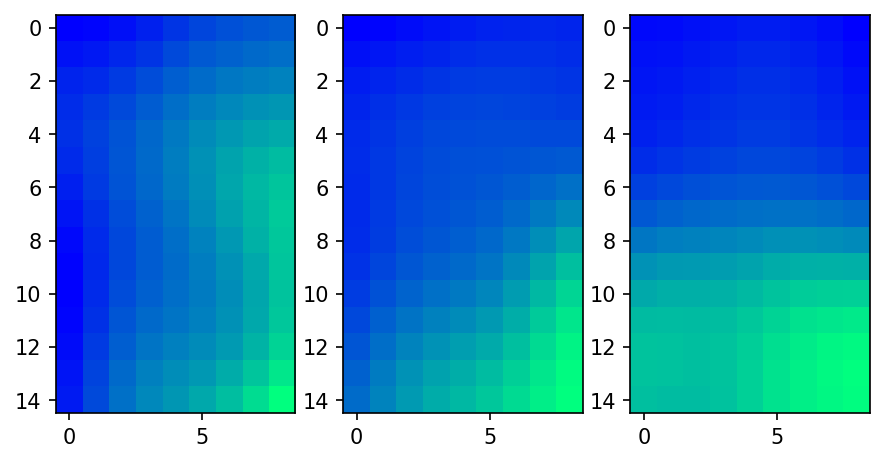

In [76]:
#@title
test_day = 1

fig, ax = plt.subplots(1,3,figsize=(7,7),dpi=150)

im1 = ax[0].imshow(y_test[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[1].imshow(y_test[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[2].imshow(y_test[test_day,2,:,:,0], cmap = plt.cm.winter)

# im1 = ax[1][0].imshow(y_test[test_day,3,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][1].imshow(y_test[test_day,4,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][2].imshow(y_test[test_day,5,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][0].imshow(y_test[test_day,6,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][1].imshow(y_test[test_day,7,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][2].imshow(y_test[test_day,8,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][0].imshow(y_test[test_day,9,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][1].imshow(y_test[test_day,10,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][2].imshow(y_test[test_day,11,:,:,0], cmap = plt.cm.winter)

# plt.colorbar(im1)

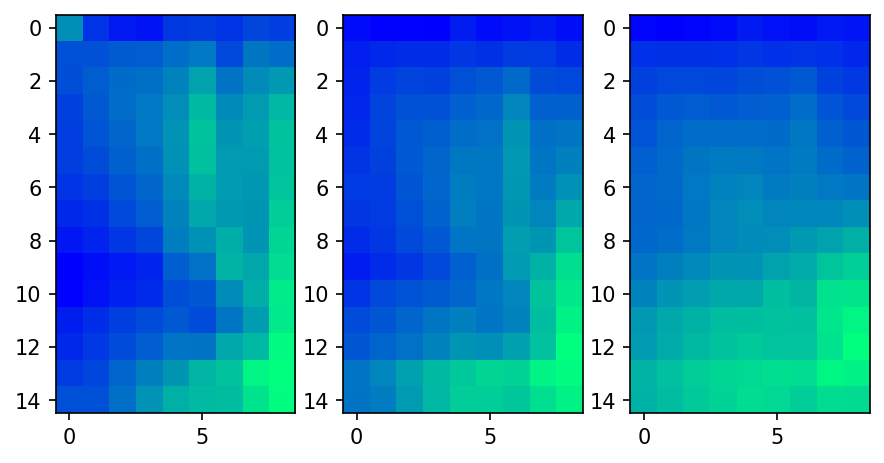

In [77]:
#@title
fig, ax = plt.subplots(1,3,figsize=(7,7),dpi=150)

im1 = ax[0].imshow(predict[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[1].imshow(predict[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[2].imshow(predict[test_day,2,:,:,0], cmap = plt.cm.winter)

# im1 = ax[1][0].imshow(predict[test_day,3,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][1].imshow(predict[test_day,4,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][2].imshow(predict[test_day,5,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][0].imshow(predict[test_day,6,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][1].imshow(predict[test_day,7,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][2].imshow(predict[test_day,8,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][0].imshow(predict[test_day,9,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][1].imshow(predict[test_day,10,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][2].imshow(predict[test_day,11,:,:,0], cmap = plt.cm.winter)

In [78]:
# tcn.save('7d2d.h5')

### RMSE计算

In [79]:
from sklearn.metrics import mean_squared_error

In [127]:
P = predict
P = P.reshape(-1,1)
P.shape

(3120390, 1)

In [128]:
R = y_test
R = R.reshape(-1,1)
R.shape

(3120390, 1)

In [82]:
mean_squared_error(R, P, squared=False)

2.045644565235602

### 计算$R^{2}$

In [83]:
from sklearn.metrics import r2_score

In [84]:
r2 = round(r2_score(P, R),4)
r2

0.8787

### 算相对误差直方图

Text(0.5, 0, 'Residual(TECU)')

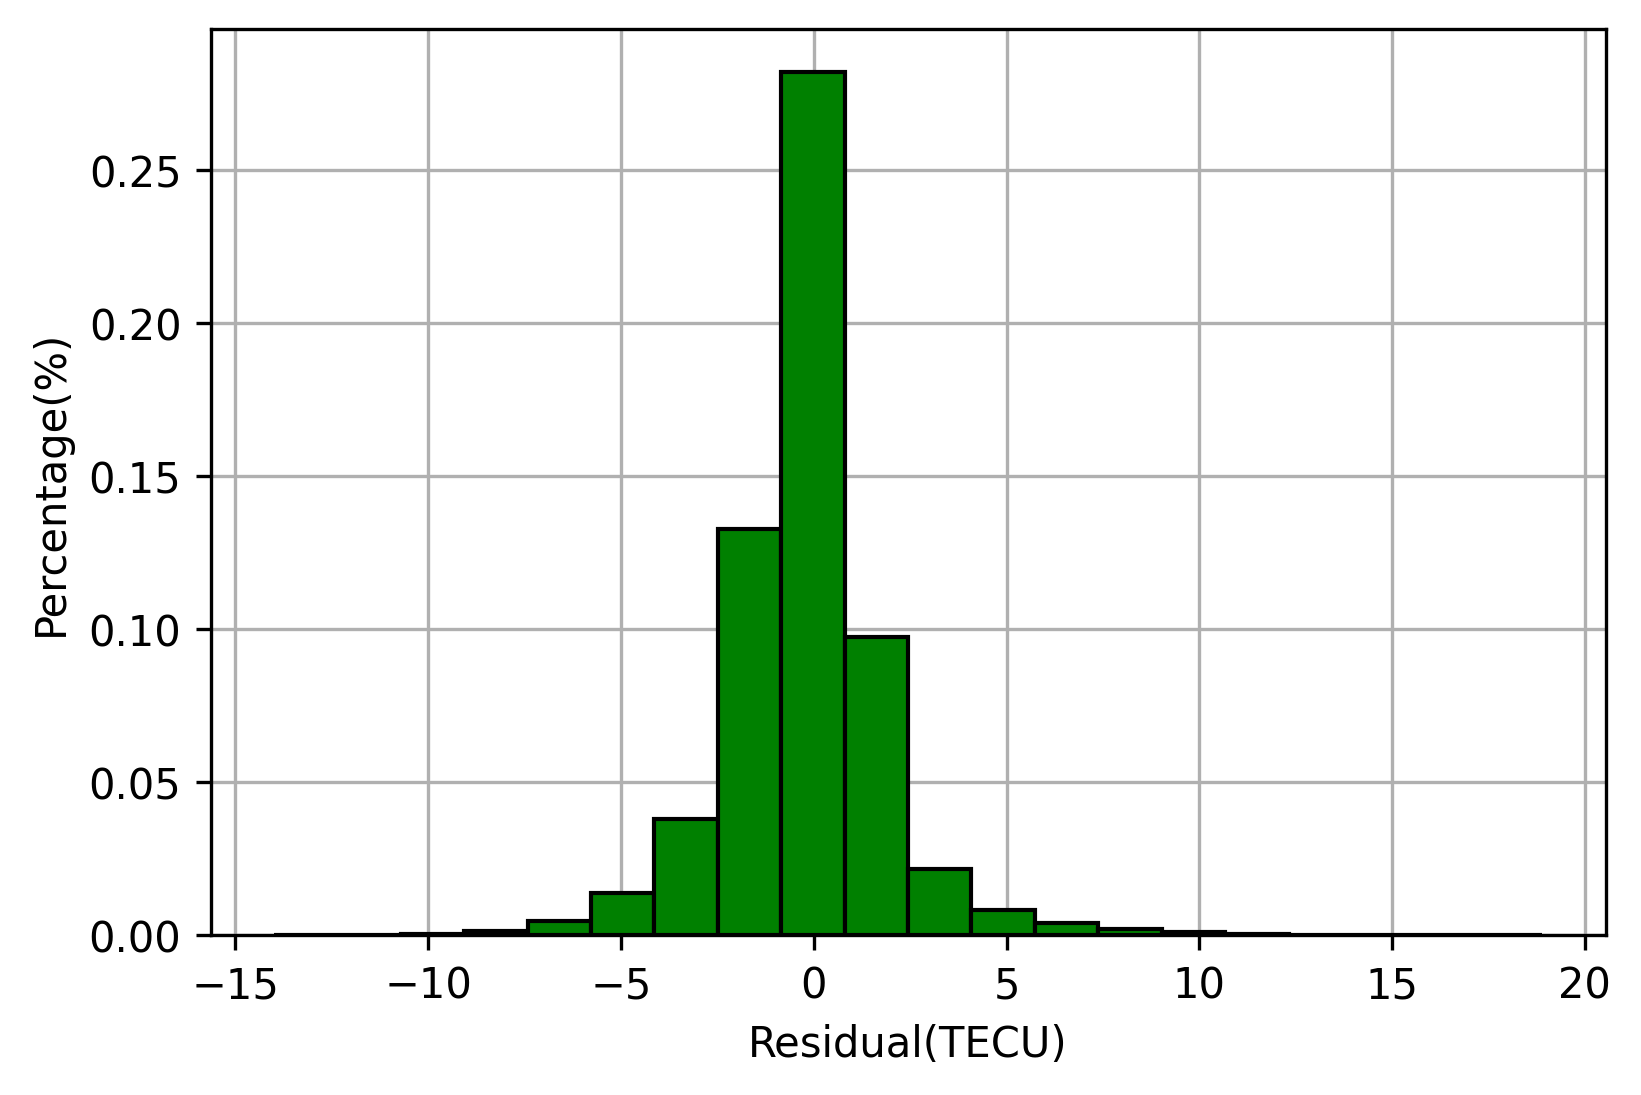

In [85]:
PD = (R-P)
fig, ax = plt.subplots(dpi=300)
ax.grid(True, zorder=1)
ax.hist(PD, bins=20, density=True, edgecolor='k',color='g',zorder=2)

ax.set_ylabel("Percentage(%)")
ax.set_xlabel("Residual(TECU)")

### 计算预测显示的散点图

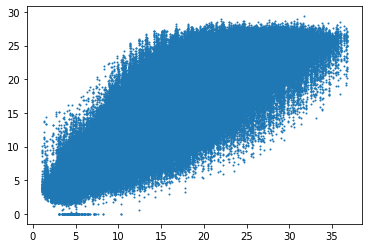

In [86]:
plt.scatter(R,P, s=1)

In [87]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(R, P)

reg.coef_, reg.intercept_

(array([[0.94033237]]), array([0.78383155]))

In [132]:
line_x = np.linspace(0, 30, 2)
y = reg.coef_[0][0] * line_x + reg.intercept_[0]
y

array([ 0.78383155, 28.99380253])

In [89]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde

In [126]:
P

array([9.038873 , 5.3938546, 6.996261 , 6.0400014, 5.6301684, 5.0674844,
       6.3220763, 5.790393 , 5.6154737, 5.8190436], dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


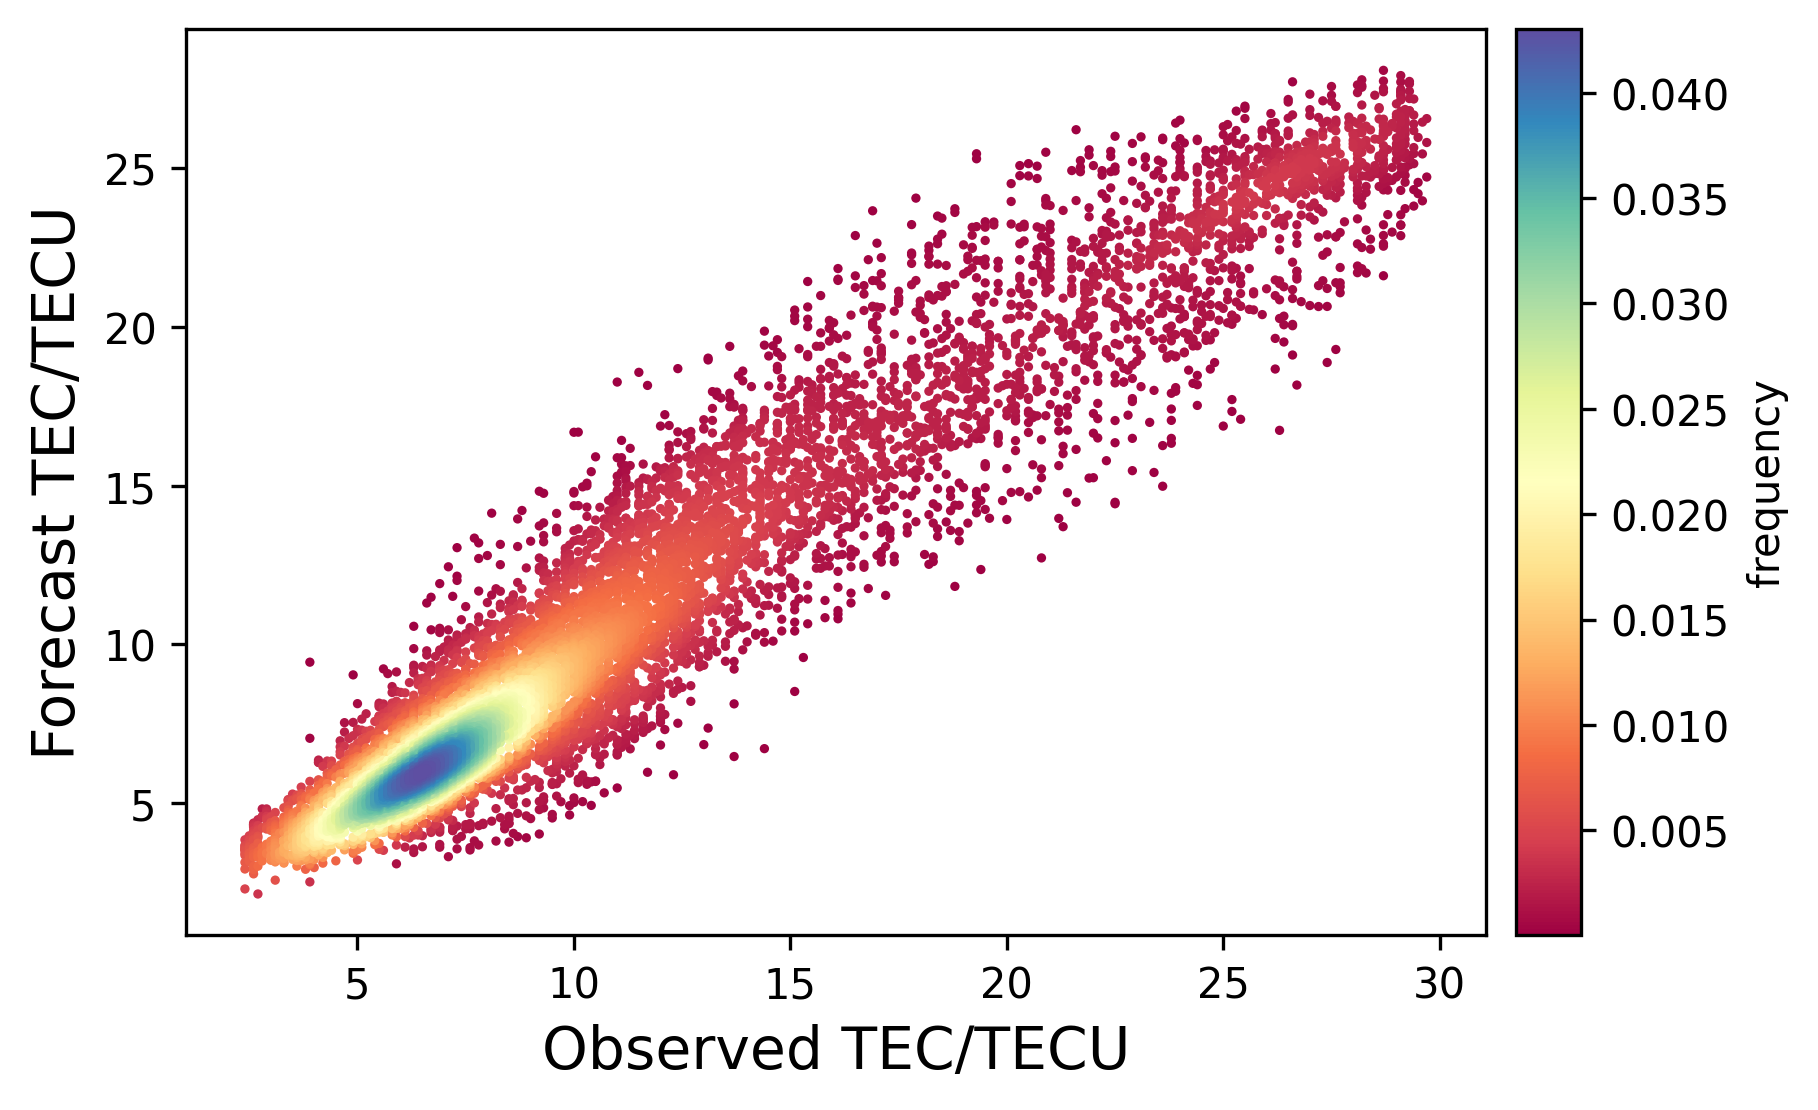

In [137]:
fig, ax = plt.subplots(dpi=300) 
R = np.squeeze(R[:])
P = np.squeeze(P[:])
xy = np.vstack([R,P])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
R,P,z = R[idx],P[idx],z[idx]
scatter = ax.scatter(R,P,s=5,c=z,marker='o',edgecolors='',cmap='Spectral')
plt.xlabel('Observed TEC/TECU', fontsize=14)
plt.ylabel('Forecast TEC/TECU', fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='frequency')

# plt.plot(line_x, y, 'k')
# # # plt.text(100, 40, r'$k_a$', fontsize=18)

# plt.text(20,5, 'R:{}\nK:{}'.format(r2, round(reg.coef_[0][0],4)))